# Crank-Nicolson demo

In [1]:
using LinearAlgebra, Plots, Printf

This implementation is again in Julia.  Since symmetric tridiagonal matrices are so prevalent and important, Julia has a special data type for them.  This makes implementing Crank--Nicolson simple.  If you are using python or Matlab you want to use the `spdiags` command. For example, in python:

```python
import numpy as np
from scipy.sparse import spdiags

m = 4
data = np.array([np.ones(m), -2.0*np.ones(m) , np.ones(m)]);
diags = np.array([-1, 0, 1])
A = spdiags(data, diags, m, m)

A.toarray()  # just to see what it looks like
```

In [4]:
h = 0.01;
m = convert(Int64,1/h)-1;
k = 0.01;
T = 10;

A = SymTridiagonal(fill(-2.0,m),fill(1.0,m-1))
r = k/(2*h^2)
Al = I - r*A
Ar = I + r*A;

## Initial and boundary data

$$ \begin{cases} u_t = u_{xx},\\
u(x,0) = \eta(x),\\
u(0,t) = g_0(t),\\
u(1,t) = g_1(t). \end{cases} $$

In [6]:
g0 = t -> t.^2/(1 .+ t.^2)*sin.(4*t)
g1 = t -> 0.
η = x -> exp.(-20*(x .-1/2).^2)
println(g0(0.))
println(η(0.))

0.0
0.006737946999085467


### Create a gif

┌ Info: Saved animation to 
│   fn = /Users/thomastrogdon/Google Drive/Sync/Teaching/586/amath-586-2020/notebooks/heat_CN.gif
└ @ Plots /Users/thomastrogdon/.julia/packages/Plots/qZHsp/src/animation.jl:98


Plots.AnimatedGif("/Users/thomastrogdon/Google Drive/Sync/Teaching/586/amath-586-2020/notebooks/heat_CN.gif")
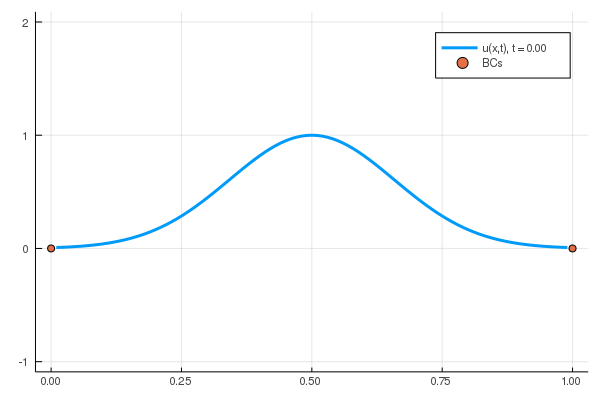

In [7]:
plot()
anim = Animation()
n = convert(Int64,ceil(T/k))
x = h:h:1-h
U = η(x)
t = 0.0
plot(x, U, xaxis = [0,1], yaxis = [-1,2],lw=3,label = @sprintf("u(x,t), t = %1.2f",t))
plot!([0,1],[g0(t),g1(t)], label = "BCs", seriestype = :scatter)
frame(anim)

fr = 100 #frames/unit time
tb = convert(Int64,ceil(n/(fr*T)))
for i = 2:n+1
    t += k
    U = Ar*U
    U[1] += r*(g0(t)+g0(t-k))
    U[2] += r*(g1(t)+g1(t-k))
    U = Al\U
    if mod(i-1,tb) ≈ 0.0 # working with i*k makes it so our framerate doesn't change with k
        plot(x, U, xaxis = [0,1], yaxis = [-1,2],lw=3,label = @sprintf("u(x,t), t = %1.2f",t))
        plot!([0,1],[g0(t),g1(t)], label = "BCs", seriestype = :scatter)
        frame(anim)
    end
end
gif(anim,"heat_CN.gif")

### Real-time plotting

In [12]:
h = 0.01;
m = convert(Int64,1/h)-1;
k = 0.01;
T = 10;
A = SymTridiagonal(fill(-2.0,m),fill(1.0,m-1))
r = k/(2*h^2)
Al = I - r*A
Ar = I + r*A;

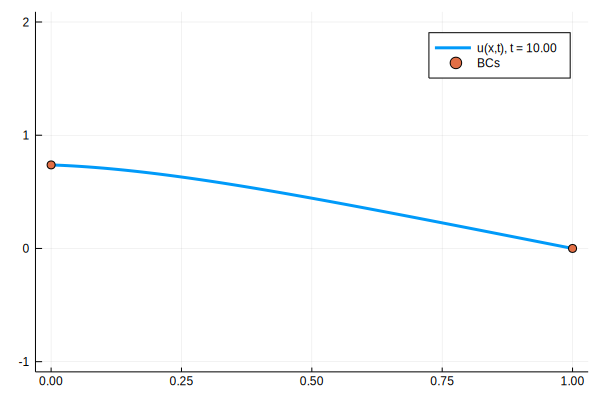

In [13]:
n = convert(Int64,ceil(T/k))
x = h:h:1-h
U = η(x)
t = 0.0
plot(x, U, xaxis = [0,1], yaxis = [-1,2],lw=3,label = @sprintf("u(x,t), t = %1.2f",t))
plot!([0,1],[g0(t),g1(t)], label = "BCs", seriestype = :scatter) |> IJulia.display

fr = 100 #frames/unit time
tb = convert(Int64,ceil(n/(fr*T)))
for i = 2:n+1
    t += k
    U = Ar*U
    U[1] += r*(g0(t)+g0(t-k))
    U[2] += r*(g1(t)+g1(t-k))
    U = Al\U
    if mod(i-1,tb) ≈ 0.0
        IJulia.clear_output(true)
        plot(x, U, xaxis = [0,1], yaxis = [-1,2],lw=3,label = @sprintf("u(x,t), t = %1.2f",t))
        plot!([0,1],[g0(t),g1(t)], label = "BCs", seriestype = :scatter) |> IJulia.display
    end
end

### Timing without plotting

In [15]:
function CN_heat(η,g0,g1,T,k,h)
    m = convert(Int64,1/h)-1;
    A = SymTridiagonal(fill(-2.0,m),fill(1.0,m-1))
    r = k/(2*h^2)
    Al = I - r*A
    Ar = I + r*A;
    n = convert(Int64,ceil(T/k))
    x = h:h:1-h
    U = η(x)
    t = 0.0

    for i = 2:n+1
        t += k
        U = Ar*U
        U[1] += r*(g0(t)+g0(t-k))
        U[2] += r*(g1(t)+g1(t-k))
        U = Al\U
    end
    U
end

CN_heat (generic function with 1 method)

In [18]:
@time CN_heat(η,g0,g1,10.,0.0001,0.0001);

 40.131320 seconds (1.00 M allocations: 29.838 GiB, 13.24% gc time)


## Forward Euler-like discretization (what not to do...)

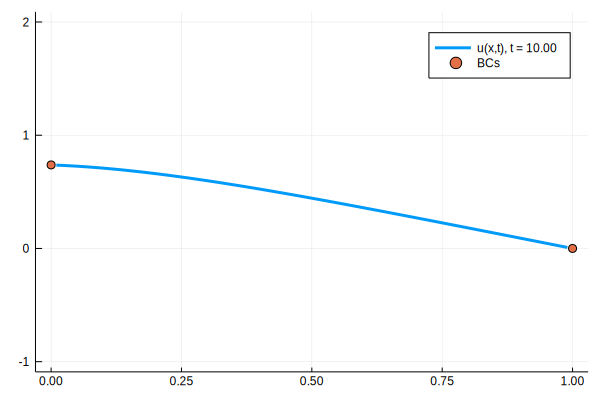

In [19]:
h = 0.01;
m = convert(Int64,1/h)-1;
k = h^2/2;  # boundary of stability region
T = 10;
A = SymTridiagonal(fill(-2.0,m),fill(1.0,m-1))
r = k/(h^2) # note that this is doubled
# Al = I - r*A # no need for this
Ar = I + r*A;

n = convert(Int64,ceil(T/k))
x = h:h:1-h
U = η(x)
t = 0.0
plot(x, U, xaxis = [0,1], yaxis = [-1,2],lw=3,label = @sprintf("u(x,t), t = %1.2f",t))
plot!([0,1],[g0(t),g1(t)], label = "BCs", seriestype = :scatter) |> IJulia.display

fr = 100 #frames/unit time
tb = convert(Int64,ceil(n/(fr*T)))
for i = 2:n+1
    t += k
    U = Ar*U
    U[1] += r*(g0(t))
    U[2] += r*(g1(t))
    # U = Al\U remove this step
    if mod(i-1,tb) ≈ 0.0
        IJulia.clear_output(true)
        plot(x, U, xaxis = [0,1], yaxis = [-1,2],lw=3,label = @sprintf("u(x,t), t = %1.2f",t))
        plot!([0,1],[g0(t),g1(t)], label = "BCs", seriestype = :scatter) |> IJulia.display
    end
end

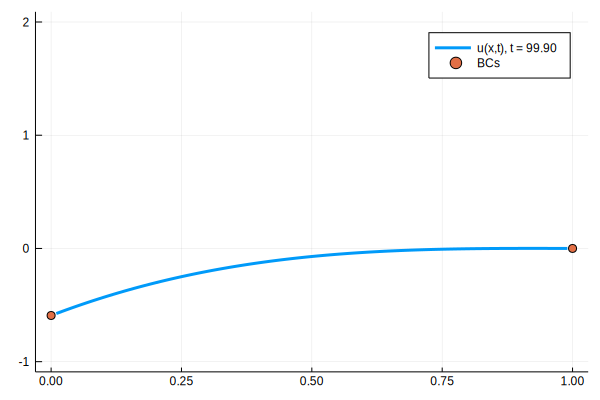

In [24]:
h = 0.01;
m = convert(Int64,1/h)-1;
k = h^2*0.50002;  # just outside of stability region
T = 100;
A = SymTridiagonal(fill(-2.0,m),fill(1.0,m-1))
r = k/(h^2) # note that this is doubled
# Al = I - r*A # no need for this
Ar = I + r*A;

n = convert(Int64,ceil(T/k))
x = h:h:1-h
U = η(x)
t = 0.0
plot(x, U, xaxis = [0,1], yaxis = [-1,2],lw=3,label = @sprintf("u(x,t), t = %1.2f",t))
plot!([0,1],[g0(t),g1(t)], label = "BCs", seriestype = :scatter) |> IJulia.display

fr = 10 #frames/unit time
tb = convert(Int64,ceil(n/(fr*T)))
for i = 2:n+1
    t += k
    U = Ar*U
    U[1] += r*(g0(t))
    U[2] += r*(g1(t))
    # U = Al\U remove this step
    if mod(i-1,tb) ≈ 0.0
        IJulia.clear_output(true)
        plot(x, U, xaxis = [0,1], yaxis = [-1,2],lw=3,label = @sprintf("u(x,t), t = %1.2f",t))
        plot!([0,1],[g0(t),g1(t)], label = "BCs", seriestype = :scatter) |> IJulia.display
    end
end